Created: 2020.08.13

Modified: 2020.08.26

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.core import parallel

import random
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from skimage.color import gray2rgb
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import directed_hausdorff

In [3]:
import sys
sys.path.append('functions')

%aimport functions00, functions01
from functions00 import *
from functions01 import *

import functions32 as f32
import functions50 as f50
import functions51 as f51

In [4]:
mk_get_host_info()

**********************************************************************************************************************************
Settings:
	HOST:  mmiv-ml-titan
	PATH_ROOT_DATA:  /data-10tb/shared/skull/train-3d-iso
	PATH_GIT_HUB:  /data-10tb/marek/github_codes/skull-stripping-1/fastai
	PATH_2D: /data-10tb/shared/skull

3D NIFTI image DF paths (_mk_3D):
	IXI_TEST_3D: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/ixi_test_mk_3d.csv
	TEST_3D : /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/test_mk_3d.csv
	TRAIN_VAL_3D: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/train_val_mk_3d.csv
	NFBS_TEST_3D: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/nfbs_test_mk_3d.csv

Error files (pickle):
	ERROR_FILES: /data-10tb/marek/github_codes/skull-stripping-1/fastai/2.2_train_valid_test_sets/error_files
***********************************************************

# 2D AXIAL - T1 biascorr 

#### Some global variables

In [41]:
TEST_SET_NAME = 'TEST_3D'
MODEL = '3.01'

SAVE_PTH_301_DATA = PATH_2D / 'pred' / MODEL / TEST_SET_NAME
SAVE_PTH_301_FIGS = PATH_2D / 'pred' / MODEL / TEST_SET_NAME / 'figs'
SAVE_PTH_301_CSV = PATH_GIT_HUB / '5.0'

In [42]:
mk_wrap_text(TEST_SET_NAME)

*****************
*** TEST_3D   ***
*****************


___

### Load 2D images of t1/biascorr, masks and predictions from a matrix

A matrix is created in notebook: 5.01_model_3.01_1_predictions.ipynb

In [43]:
%%time
load = 0
if load:
    save_name = f'{MODEL}_{TEST_SET_NAME}_uncompressed_results.npz'
    save_pth = SAVE_PTH_301_DATA / save_name
    X = np.load(save_pth, allow_pickle=True)
    
    full_names = X['full_names']
    fsl_128 = X['fsl_128']
    pred_128 = X['pred_128']
    x_128 = X['x_128']
    mask_full_path = X['mask_full_path']
    print(f'Loaded N={len(full_names)} 2D slices (128x128) of t1/biascoor (x), FSL_output (y) and prediction (p) images.\n')

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 6.91 µs


___

Based on index obtained from df (5.01_model_3.01_1_TEST_predictions.ipynb) we can manipulate data loaded from a npz file: 
- fsl_128 - fsl_output (y) slices interpolated by fastai to a model size (128x128xN),
- pred_128 -  predicted masks (p), (128x128xN),
- x_128 -  t1/biascorr images (x) interpolated by fastai image to a model size (128x128xN),
- full_names - list of t1/biascorr 'original' 2D image path,
- mask_full_path - list of 2D 'original' mask path,

where N is equalled to number of all 2D slices (every 3D examination in every db) in the TEST_SET 


### Prepare df info for each slice or load it from a file

*df_2d* contains paths to all 2D slices (has N rows)


In [44]:
create_df_2d = 0
save = 0

save_name = f'{MODEL}_{TEST_SET_NAME}_info_2d.csv'
save_pth = SAVE_PTH_301_CSV / save_name

# Create df 
if create_df_2d:
    # Data frame with paths for 2D slices 
    df_2d = pd.DataFrame.from_dict({'full':full_names, 'mask_full_path': mask_full_path})

    # common name part for each examination (without slice number e.g 001) from an image
    df_2d['patient'] = df_2d.full.apply(lambda x: x[:-7])

    # identify the database
    for db in ['ADNI', 'AIBL', 'IXI', 'PPMI', 'SALD', 'SLIM', 'CalgaryCampinas']:
        df_2d.loc[df_2d.full.str.contains(db), 'db'] = db 


    if save:
        df_2d.to_csv(save_pth, index=False)
else:
    df_2d = pd.read_csv(save_pth)
    
    
print(df_2d.shape)
df_2d.head(2)

(157036, 4)


,full,mask_full_path,patient,db
0,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N...,/data-10tb/shared/skull/axial-2d/test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N3...,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N...,ADNI
1,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N...,/data-10tb/shared/skull/axial-2d/test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N3...,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N...,ADNI


### Prepare df for each 3d image 

*df_3d* contains paths to:
1. full : the first 2D t1/biascorr image name \*.000.png,
1. mask_full_path: the first 2D mask image name \*.000.png,
1. patient: common part of the name for all the same patient images e.g. examination_number_t1_biascorr_, to identify all 2d slices that belong to the same examination,
1. db : database name: IXI, ADNI, ...
1. dice: dice coeff. value,
1. jaccard: jaccard coeff. value,
1. hausdorff: Hausdorff distance.


In [45]:
create_df_3d = 0
save = 0

save_name = f'{MODEL}_{TEST_SET_NAME}_dice_jaccard_3d.csv'
save_pth = SAVE_PTH_301_CSV / save_name

if create_df_3d:
    # Data frame for 3d - contains Dice and Jaccard coefs

    # Get list of all patients (name patterns)
    pat = f50.get_all_patient_list_from_df(df_2d)

    idxs = []
    # get the index of the first 2d slice for each examination (*_000.png)
    for p in pat:
        # list of all first indices of 2d slice from all patients (examinations, *_000.png)
        idxs.append(df_2d[df_2d.patient == p].index[0])
        
    # create df_3d from first slices of each pathient from df_2d
    df_3d = df_2d.iloc[idxs]

    # add some zero filled column for coefficients
    df_3d = df_3d.assign(dice=0)
    df_3d = df_3d.assign(jaccard=0)
    df_3d = df_3d.assign(hausdorff=0)

    if save:
        df_3d.to_csv(save_pth, index=False)

# load existing df from a csv file
else:
    df_3d = pd.read_csv(save_pth)

print(df_3d.shape)
df_3d.head(4)

(927, 7)


,full,mask_full_path,patient,db,dice,jaccard,hausdorff
0,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N...,/data-10tb/shared/skull/axial-2d/test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N3...,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N...,ADNI,0.981809,0.964268,3.605551
1,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR__GradWarp__B1_Correction__N3_...,/data-10tb/shared/skull/axial-2d/test/ADNI/ADNI_011_S_0005_MR_MPR__GradWarp__B1_Correction__N3__...,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR__GradWarp__B1_Correction__N3_...,ADNI,0.981435,0.963546,4.000000
2,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR__GradWarp__B1_Correction__N3_...,/data-10tb/shared/skull/axial-2d/test/ADNI/ADNI_011_S_0005_MR_MPR__GradWarp__B1_Correction__N3__...,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR__GradWarp__B1_Correction__N3_...,ADNI,0.982607,0.965809,3.162278
3,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N...,/data-10tb/shared/skull/axial-2d/test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N3...,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N...,ADNI,0.982206,0.965035,4.690416


### Get every 3d image and calculate Dice, Jaccard and Hausdorf (sum and mean) coef's

In [46]:
%%time

calculate_metrics = 0
save = 0

dice_jaccard_hausdorff = "HDJ" # "DJH"


if calculate_metrics:
    # get the examination names
    patients = df_3d.patient

    dice = []
    jaccard = []
    hausdorff = []

    l = len(patients) # total number of examinations
    k = 0 # progress indicator

    for pat in patients:
        # Get all 2D slices from df_2d data frame as new dfp and its indices
        # idxp - indices of all 2D slices usually 170 (number of slices)
        dfp, idxp = f50.get_one_patient(df_2d, pat)
        #print(len(idxp))

        # Get a 3D images of a single patient (e.g. 170x128x128)
        xP = x_128[idxp]   # 3D image  128x128xslices
        yP = fsl_128[idxp]  # 3D fsl_output  128x128xslices
        pP = pred_128[idxp]  # 3D predictions  128x128xslices
        
        # Check shape of 2D matix, its 'flat[:]' version and  its size - OK, all are equalled to each other
        #print(xP.shape, xP.size, xP.flat[:].shape, xP.flat[:].size)
        
        # calculate dice/jaccard/housdorff if needed
        if 'D' in dice_jaccard_hausdorff:
            dice.append(f50.dice(yP.flat[:], pP.flat[:]))
            
        if 'J' in dice_jaccard_hausdorff:
            jaccard.append(jaccard_score(yP.flat[:], pP.flat[:]))
            
        # how to calculate it? what metric? total sum?
        if 'H' in dice_jaccard_hausdorff:
            hausdorff.append(f51.Hausdorff_distance(yP, pP))
        
        print(f'{k}/{l}', end='\r')
        k += 1  
    
    # Update the df_3d with calculated coefficitnts
    if 'D' in dice_jaccard_hausdorff:
        df_3d['dice']= list(dice)
    if 'J' in dice_jaccard_hausdorff:
        df_3d['jaccard']=list(jaccard)     
    if 'H' in dice_jaccard_hausdorff:
        df_3d['hausdorff'] = list(hausdorff)        
    
    if save:
        save_name = f'{MODEL}_{TEST_SET_NAME}_dice_jaccard_3d.csv'
        save_pth = SAVE_PTH_301_CSV / save_name
        df_3d.to_csv(save_pth, index=False)
    
print(df_3d.shape)
df_3d.head(2)    

(927, 7)
CPU times: user 380 µs, sys: 19 µs, total: 399 µs
Wall time: 335 µs


,full,mask_full_path,patient,db,dice,jaccard,hausdorff
0,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N...,/data-10tb/shared/skull/axial-2d/test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N3...,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR-R__GradWarp__B1_Correction__N...,ADNI,0.981809,0.964268,3.605551
1,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR__GradWarp__B1_Correction__N3_...,/data-10tb/shared/skull/axial-2d/test/ADNI/ADNI_011_S_0005_MR_MPR__GradWarp__B1_Correction__N3__...,/data-10tb/shared/skull/axial-2d//test/ADNI/ADNI_011_S_0005_MR_MPR__GradWarp__B1_Correction__N3_...,ADNI,0.981435,0.963546,4.000000


### Print Dice & Jaccard coef's

In [48]:
f50.print_dice_jaccard_1(df_3d)

**********************************************************************
Global:
    Dice:       max=0.9871, min=0.8545, | mean=0.9778, std=0.0131
    Jaccard:    max=0.9745, min=0.7460, | mean=0.9569, std=0.0236
    Hausdorff    max=47.3709, min=2.2361, | mean=5.6711, std=4.7215
**********************************************************************
ADNI:
    Dice:       max=0.9835, min=0.8545, | mean=0.9745, std=0.0167
    Jaccard:    max=0.9675, min=0.7460, | mean=0.9507, std=0.0299 
    Hausdorff:  max=47.3709, min=2.2361, | mean=6.8388, std=5.7655
AIBL:
    Dice:       max=0.9844, min=0.9324, | mean=0.9812, std=0.0051
    Jaccard:    max=0.9693, min=0.8733, | mean=0.9632, std=0.0096 
    Hausdorff:  max=25.8070, min=2.2361, | mean=3.8487, std=2.5966
CalgaryCampinas:
    Dice:       max=0.9849, min=0.9358, | mean=0.9806, std=0.0088
    Jaccard:    max=0.9702, min=0.8794, | mean=0.9621, std=0.0164 
    Hausdorff:  max=20.4206, min=2.2361, | mean=4.9782, std=4.4779
PPMI:
    Dice:      

In [37]:
f50.print_dice_jaccard_2(df_3d, print_dice=True, print_jaccard=True, print_hausdorff=True)


******************* Dice ********************
      |  max,     min   |     mean,     std 
GLOB. | 0.9856,    0.8838, |    0.9791,    0.0076
*********************************************
IXI: | 0.9856,    0.8838, |    0.9791,    0.0076
*********************************************

****************** Jaccard ******************
      |  max,     min   |     mean,     std 
GLOB. | 0.9715,    0.7918, |    0.9591,    0.0139
*********************************************
IXI: | 0.9715,    0.7918, |    0.9591,    0.0139
*********************************************

***************** Hausdorff *****************
      |  max,     min   |     mean,     std 
GLOB. | 52.8583,    2.0000, |    5.7811,    5.4777
*********************************************
IXI: | 52.8583,    2.0000, |    5.7811,    5.4826
*********************************************


___

## Visualization

### For data bases

Saved figure to: /data-10tb/shared/skull/pred/3.01/IXI_TEST_3D/figs/3.01_IXI_TEST_3D_dice_dbs.png
Saved figure to: /data-10tb/shared/skull/pred/3.01/IXI_TEST_3D/figs/3.01_IXI_TEST_3D_jaccard_dbs.png
Saved figure to: /data-10tb/shared/skull/pred/3.01/IXI_TEST_3D/figs/3.01_IXI_TEST_3D_hausdorff_dbs.png


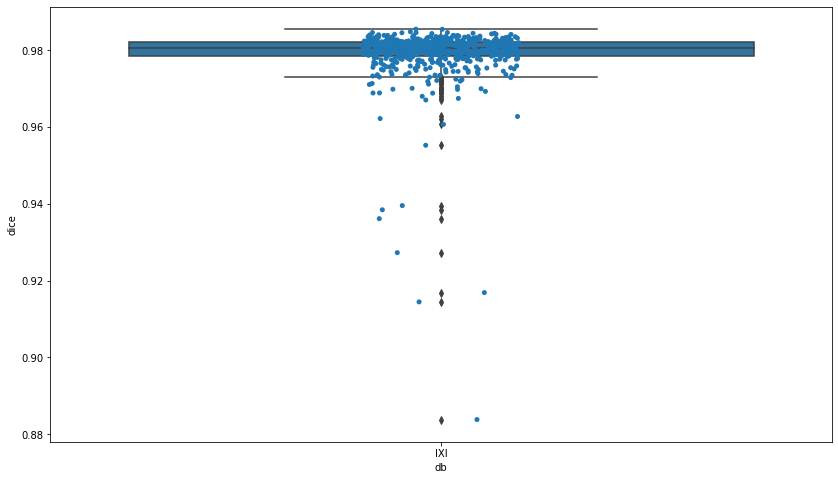

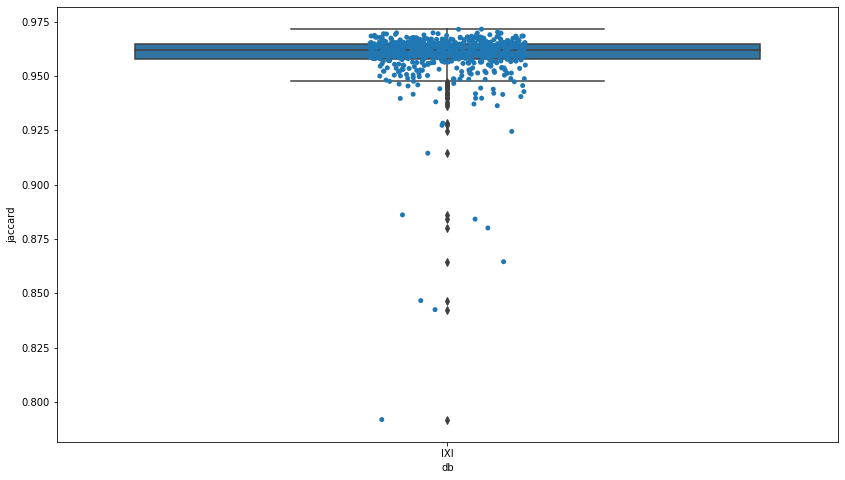

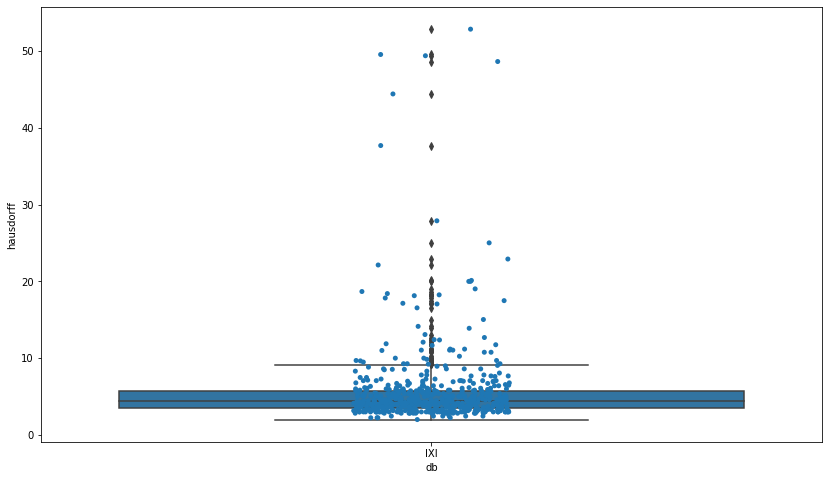

In [19]:
cols = ['dice', 'jaccard', 'hausdorff']

save = 1
figsize = (14,8)
    
for col in cols:
    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(ax=ax, x='db', y=col, data=df_3d)
    sns.stripplot(ax=ax, x='db', y=col, data=df_3d)
    
    if save:
        save_name = f'{MODEL}_{TEST_SET_NAME}_{col}_dbs.png'
        save_pth = SAVE_PTH_301_FIGS / save_name        
        plt.savefig(save_pth)
        print(f'Saved figure to: {save_pth}')

### Global

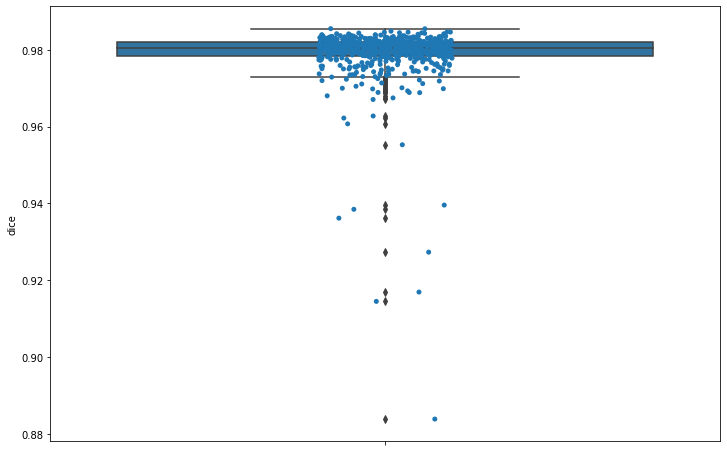

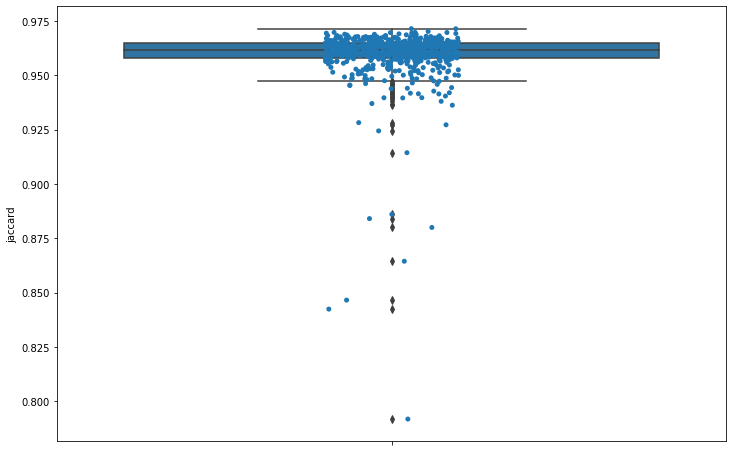

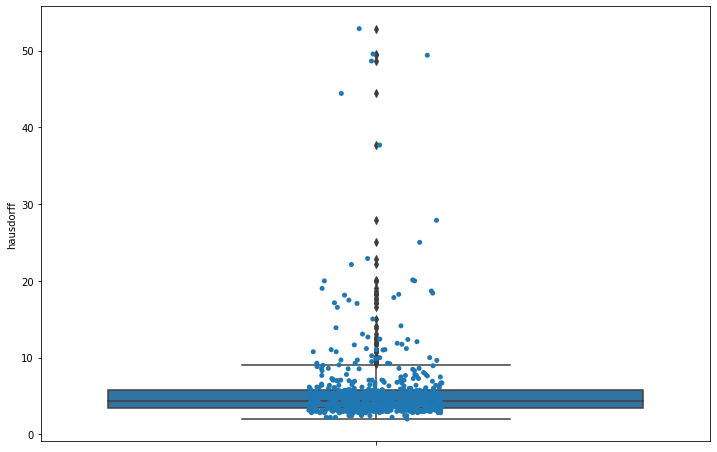

In [20]:
cols = ['dice', 'jaccard', 'hausdorff']

save = 0
figsize = (14,8)
    
for col in cols:

    fig, ax = plt.subplots(figsize=(12,8))
    sns.boxplot(ax=ax, y=col, data=df_3d)
    sns.stripplot(ax=ax, y=col, data=df_3d)

    if save:
        save_name = f'{MODEL}_{TEST_SET_NAME}_{col}_glob.png'
        save_pth = SAVE_PTH_301_FIGS / save_name        
        plt.savefig(save_pth)
        print(f'Saved figure to: {save_pth}')

## Violin plots

#### IXI_TEST_3D

In [39]:
save_name = f'3.01_IXI_TEST_3D_dice_jaccard_3d.csv'
save_pth = SAVE_PTH_301_CSV / save_name
df_3d = pd.read_csv(save_pth)
print(df_3d.shape)
df_model_2d = df_3d[['dice', 'jaccard']]
df_model_2d = df_model_2d.assign(model='2d', db='ixi')
df_model_2d.head(1)

(556, 8)


,dice,jaccard,model,db
0,0.983481,0.967499,2d,ixi


In [40]:
n3d = PATH_GIT_HUB / 'inne_lokalne/' / 'sathiesh_3d_results' / 'ixi_test_results.csv'
df_model_3d = pd.read_csv(n3d)
df_model_3d = df_model_3d[['dice_score', 'jaccard_score']]
df_model_3d.columns = ['dice', 'jaccard']
df_model_3d = df_model_3d.assign(model='3d', db='ixi')
print(df_model_3d.shape)
df_model_3d.head(1)

(556, 4)


,dice,jaccard,model,db
0,0.983632,0.967791,3d,ixi


In [41]:
df_all = pd.concat([df_model_2d, df_model_3d],sort=False)
df_all.shape

(1112, 4)

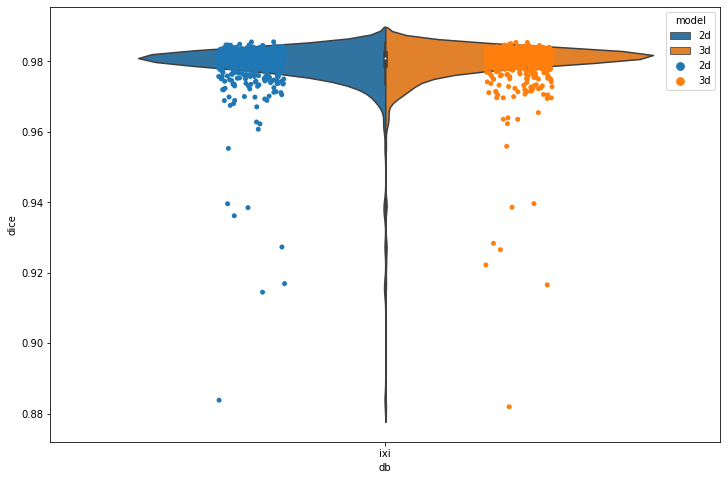

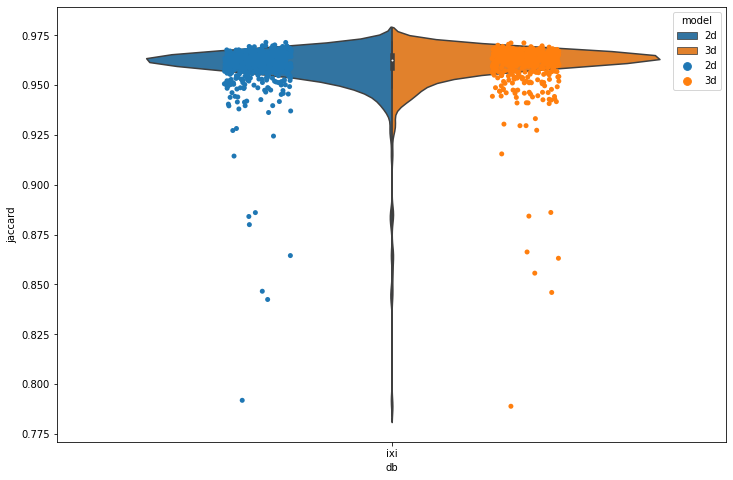

In [42]:
cols = ['dice', 'jaccard']

save = 0
figsize = (12,8)
    
for col in cols:
    violin, ax = plt.subplots(figsize=figsize)
    ax = sns.violinplot(x='db', y=col, hue='model', data=df_all, split=True)
    ax = sns.stripplot(x="db", y=col, hue='model', data=df_all, dodge=True)
    if save:
        save_pth = f'/data-10tb/shared/skull/pred/3.01/IXI_TEST_3D/figs/3.01_IXI_TEST_3D_{col}_violin.png'
        plt.savefig(save_pth)
        print(f'Saved figure to: {save_pth}')

#### TEST_3D

In [43]:
save_name = f'3.01_TEST_3D_dice_jaccard_3d.csv'
save_pth = SAVE_PTH_301_CSV / save_name
df_3d = pd.read_csv(save_pth)
print(df_3d.shape)
df_model_2d = df_3d[['dice', 'jaccard', 'db']]

#idx = df_model_2d[df_model_2d['db']=='CalgaryCampinas'].index
df_model_2d.loc[df_model_2d.db.str.contains('CalgaryCampinas'), 'db'] = 'CC' 

df_model_2d = df_model_2d.assign(model='2d')
df_model_2d.head(2)

(927, 8)


/home/marek/anaconda3/envs/fastai1/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,dice,jaccard,db,model
0,0.981809,0.964268,ADNI,2d
1,0.981435,0.963546,ADNI,2d


In [44]:
n3d = PATH_GIT_HUB / 'inne_lokalne/' / 'sathiesh_3d_results' / 'test_results.csv'
df_model_3d = pd.read_csv(n3d)
df_model_3d = df_model_3d[['dice_score', 'jaccard_score', 'source']]
df_model_3d.columns = ['dice', 'jaccard', 'db']
df_model_3d = df_model_3d.assign(model='3d')
print(df_model_3d.shape)
df_model_3d.head(2)

(927, 4)


,dice,jaccard,db,model
0,0.981304,0.963293,ADNI,3d
1,0.981175,0.963046,ADNI,3d


In [45]:
df_all = pd.concat([df_model_2d, df_model_3d],sort=False)
print(df_all.shape)
df_all.head(2)

(1854, 4)


,dice,jaccard,db,model
0,0.981809,0.964268,ADNI,2d
1,0.981435,0.963546,ADNI,2d


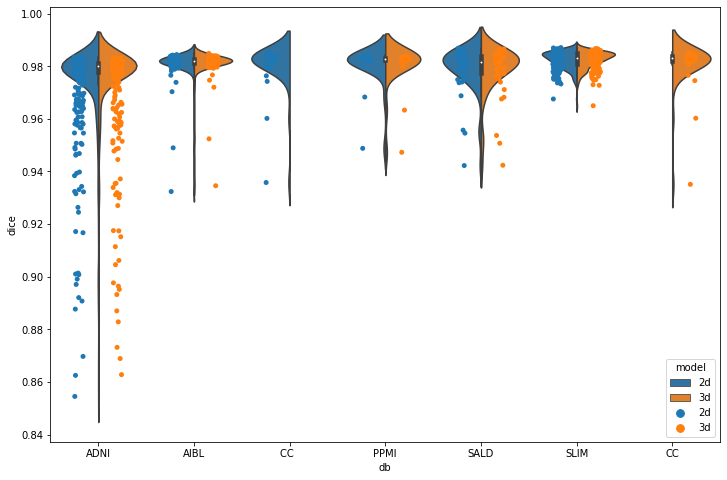

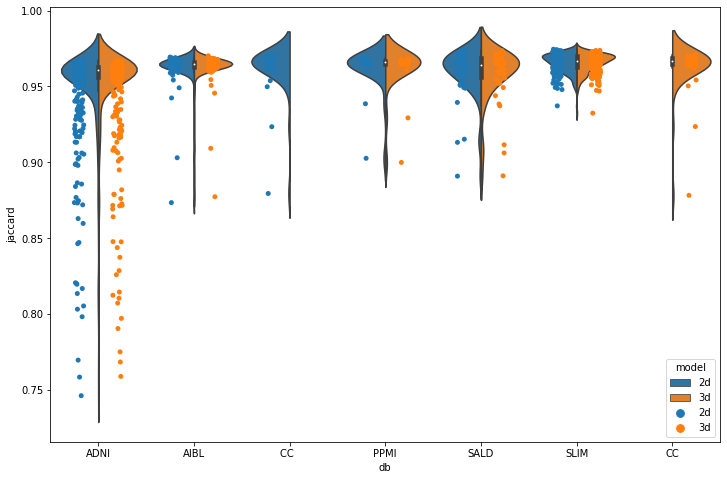

In [46]:
cols = ['dice', 'jaccard']

save = 0
figsize = (12,8)
    
for col in cols:
    violin, ax = plt.subplots(figsize=figsize)
    ax = sns.violinplot(x='db', y=col, hue='model', data=df_all, split=True)
    ax = sns.stripplot(x="db", y=col, hue='model', data=df_all, dodge=True)
    if save:
        save_pth = f'/data-10tb/shared/skull/pred/3.01/TEST_3D/figs/3.01_TEST_3D_{col}_violin.png'
        plt.savefig(save_pth)
        print(f'Saved figure to: {save_pth}')

___

### Identification of the smallest coefficient

In [45]:
tests = 0
if tests:
    dfs, idxs = f50.get_biggest_smallest_dice_jaccard_coefs(df_3d, db='IXI', sort_column='dice', max_min = 'min', N=3)
    print(idxs)
    dfs[['patient', 'dice', 'jaccard']]

#### TESTS

In [44]:
tests = 0
if tests:
    # Get names from df; identify db's in a test set
    print(f50.get_db_names(df))
    
    # Get one db from the entire test set
    dfn, idx = f50.get_single_db(df,'PPMI')
    
    # get patients name from a full df or a choosen DB
    pat = f50.get_all_patient_list_from_df(dfn)
    print(len(pat))
    
    pt = pat[0]
    dfp, idxp = f50.get_one_patient(dfn, pt)
    print(idxp)
    
    
    # Get images of a patient
    # one patient (P) indices, acquired above

    xP = x_128[idxp]
    yP = fsl_128[idxp]
    pP = pred_128[idxp]
    
    print(xP.size, xP.shape)
    
    dfs, idxs = f50.get_biggest_smallest_dice_jaccard_coefs(df_3d, db='SALD', sort_column='dice', max_min = 'min', N=7)
    print(idxs)
    dfs

___